# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))

    three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

56 57 72


In [ ]:
# Test the schedule adjustment solve with exact method
reward_mode=2
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=prd.extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,drivingcost_per_mile,num_time_interval)
R=prd.estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim,reward_mode,superzone_map,drivingcost_per_mile)
num_cav=1
run_mode=2
single_model_runtime=60*30
m1,x,y,T,obj1,obj2,obj3=sod.dial_n_ride_model_schedule_adjustment(num_hh_member,hh_num_trips,C,TT,TL,TU,sorted_trips,
                    expected_arrival_time,early_penalty,late_penalty,
                    early_penalty_threshold,late_penalty_threshold,R,Vehicular_Skim,
                    share_ride_factor,output_flag,run_mode,reward_mode,
                    num_cav,num_time_interval,cav_use_mode,time_window_flag,single_model_runtime)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*0.5
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=1
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU)])

In [ ]:
sod.move_neighborhood(x_sol,T_sol,initial_route_info,hh_num_trips,
                      num_cav,shake_size,Vehicular_Skim_Dict)

In [ ]:
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone\
    =prd.extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,drivingcost_per_mile,num_time_interval)

In [ ]:
print(datetime.datetime.now())
m3,T,S=sod.optimal_start_time(sorted_trips,x_sol[:,:,0],T_sol,hh_num_trips,expected_arrival_time,Vehicular_Skim_Dict,visit_candidate_zone,
    early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,superzone_map)
print(datetime.datetime.now())

# Solve for all households car trips only

##### Compare the exact method and schedule method for one household

In [38]:
output_flag=1
target_hh_id=364652
min_length=15
max_length=20
single_model_runtime=60*2
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=2
share_ride_factor=1.5
time_window_flag=0
print(datetime.datetime.now())
# route_info1=sod.find_av_schedule_exact_method(target_hh_id,traveler_trips.loc[traveler_trips.tripmode<=6],output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
#                          reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
#                          ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU)
# print(datetime.datetime.now())
# target_hh=traveler_trips[(traveler_trips['hh_id']==target_hh_id) &(traveler_trips.tripmode<=6)]\
#         .drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
#                                  'starttime','joint_trip_flag'])
# #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
# sorted_trips=target_hh.sort_values("starttime")

target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

community_hh_list=[972044,972024,2212041] #,2212030,937968,2285653,1309779,1738127,2034377,2066988]
community_trips=pd.DataFrame()
for hh_id in community_hh_list:
#     print(len(target_trips[target_trips.hh_id==hh_id]))
    community_trips=community_trips.append(target_trips[target_trips.hh_id==hh_id])
sorted_trips=community_trips.sort_values('starttime')
hh_num_trips=sorted_trips.shape[0]

sorted_trips["hh_index"]=(range(hh_num_trips))
print(datetime.datetime.now())
darp_solution2=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)
print(datetime.datetime.now())

2018-07-15 18:44:33.092630
2018-07-15 18:44:33.427646
11 [ 972024 2212041  972044] 11
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 120.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 1854 rows, 1200 columns and 9986 nonzeros
Variable types: 48 continuous, 1152 integer (1152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Presolve removed 741 rows and 462 columns
Presolve time: 0.05s
Presolved: 1113 rows, 738 columns, 6338 nonzeros
Variable types: 48 continuous, 690 integer (690 binary)
Found heuristic solution: objective -60.0200000

Root relaxation: objective 1.

   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 120.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 3707 rows, 2380 columns and 21486 nonzeros
Variable types: 68 continuous, 2312 integer (2312 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint FromDepot2[0,1] by 1.000000000

Presolve removed 1634 rows and 1044 columns
Presolve time: 0.10s
Presolved: 2073 rows, 1336 columns, 12364 nonzeros
Variable types: 68 continuous, 1268 integer (1268 binary)
Found heuristic solution: objective -60.0200000

Root relaxation: objective 1.403495e+04, 795 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     

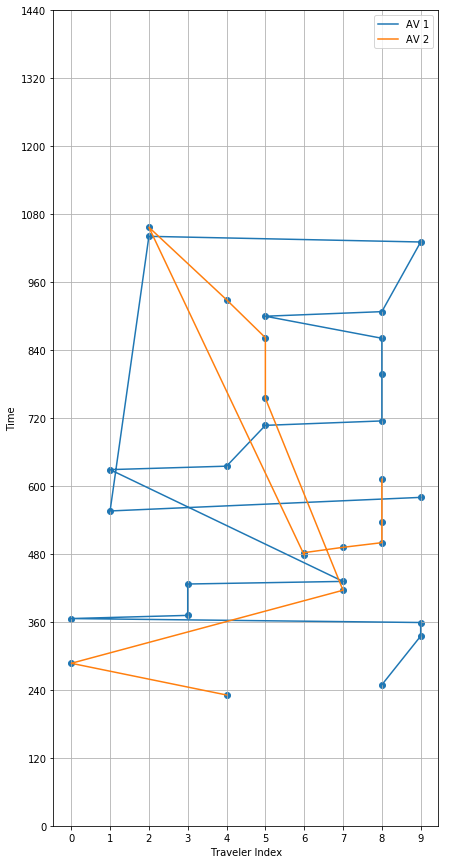

In [37]:
pod.plot_route_info_schedule(darp_solution2['route_info'],community_trips,num_cav)

In [30]:
community_route_info=darp_solution2['route_info']

In [39]:
community_route_info

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index,p_id
0,7,5,2,39,7511986,249.00,254.90,254.9,0.1373,249.0,32.1,972024.0,0.0,0,0,972024.0_0_0.0,8
1,5,7,39,4,0,254.90,335.00,335.0,0.0100,287.0,0.0,972024.0,0.0,0,1,972024.0_1_0.0,-1
2,7,14,4,41,7511987,335.00,340.00,340.0,0.1373,335.0,9.0,972024.0,0.0,0,2,972024.0_2_0.0,9
3,14,14,41,7,0,340.00,359.00,362.0,0.0100,349.0,0.0,972024.0,0.0,0,3,972024.0_3_0.0,-1
4,14,7,7,44,7511987,359.00,361.90,364.9,0.1373,362.0,1.1,972024.0,0.0,0,4,972024.0_4_0.0,9
5,7,9,44,8,0,361.90,366.00,366.0,0.0100,366.0,0.0,972024.0,0.0,0,5,972024.0_5_0.0,-1
6,9,7,8,45,3260784,366.00,366.50,366.5,0.1509,366.0,49.5,972024.0,0.0,0,6,972024.0_6_0.0,0
7,7,7,45,5,0,366.50,371.60,349.0,0.0100,416.0,0.0,972024.0,0.0,0,7,972024.0_7_0.0,-1
8,7,4,5,42,3260791,371.60,379.70,357.1,0.1509,349.0,0.0,972024.0,0.0,0,8,972024.0_8_0.0,3
9,4,4,42,10,0,379.70,427.00,427.0,0.0100,350.0,0.0,972024.0,0.0,0,9,972024.0_9_0.0,-1


In [31]:
community_route_info[community_route_info.hh_vehicle_id==1]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index,p_id
0,7,12,1,38,3260792,231.0,237.7,237.7,0.1509,231.0,11.3,972024.0,1.0,0,0,972024.0_0_1.0,4
1,12,7,38,3,0,237.7,287.0,287.0,0.0100,249.0,0.0,972024.0,1.0,0,1,972024.0_1_1.0,-1
2,7,12,3,40,3260784,287.0,293.7,293.7,0.1509,287.0,41.3,972024.0,1.0,0,2,972024.0_2_1.0,0
3,12,7,40,9,0,293.7,416.0,416.0,0.0100,335.0,0.0,972024.0,1.0,0,3,972024.0_3_1.0,-1
4,7,8,9,46,3260909,416.0,418.1,418.1,0.0318,416.0,8.9,972024.0,1.0,0,4,972024.0_4_1.0,7
0,12,7,27,64,3260903,755.0,756.5,756.5,0.0318,755.0,40.5,972024.0,1.0,0,5,972024.0_5_1.0,5
1,7,7,64,30,0,756.5,862.0,862.0,0.0100,797.0,0.0,972024.0,1.0,0,6,972024.0_6_1.0,-1
2,7,5,30,67,3260903,862.0,867.8,867.8,0.0318,862.0,40.2,972024.0,1.0,0,7,972024.0_7_1.0,5
3,5,12,67,32,0,867.8,929.0,929.0,0.0100,908.0,0.0,972024.0,1.0,0,8,972024.0_8_1.0,-1
4,12,7,32,69,3260792,929.0,930.6,930.6,0.1509,929.0,0.4,972024.0,1.0,0,9,972024.0_9_1.0,4


In [ ]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

route_info_allcartrips15,darp_solutions_allcartrips_temp15=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU,transit_zone_dict)

In [ ]:
import pickle
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcartrips15.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcartrips_temp15,'darp_solutions',output_filepath)

In [ ]:
darp_solutions_allcartrips_temp15

In [ ]:

if not os.path.exists(route_info_path):
    os.makedirs(route_info_path)
route_info_allcartrips15.to_csv(route_info_path+'route_info.csv')

vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
dtd.route_to_vehiclepathdat(route_info_allcartrips,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
allcar_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
allcar_target_trips=allcar_target_trips[(allcar_target_trips.orig_taz!=allcar_target_trips.dest_taz) 
                                        | (allcar_target_trips.trip_counter==1)]
allcar_target_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag','hh_id'],inplace=True)

In [ ]:
target_solution

In [ ]:
i=0
target_hh_id=241508
for solution in darp_solutions_allcartrips_temp15:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp=solution['route_info'].hh_id.iloc[0]
        if (temp)==(target_hh_id):
            target_solution=solution
#     i=i+1

pod.plot_route_info_schedule(target_solution['route_info'],
                             allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],num_cav)

In [ ]:
pod.analysis_result(target_solution,allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],Vehicular_Skim_Dict,superzone_map)

In [ ]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])
value_of_time_discount_factor=0.9
target_trips['value_of_time']=target_trips['value_of_time']*value_of_time_discount_factor

route_info_modechioce09,darp_solutions_modechoice09=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

In [ ]:
run_name='modechoice09/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_modechioce09.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_modechoice09,'darp_solutions',output_filepath)
vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'

z=route_info_modechioce09
external_vehicle_filepath='Input/external_vehicle50.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath+'external50/'
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
z=dtd.preprocess_routeinfo_for_vehicledat(z)
dtd.route_to_vehiclepathdat(z,origin_links,output_filepath,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*5
drivingcost_per_mile=1
reward_mode=0
darp_solutions1=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

# for num_cav in [2]: #range(1,4):
#     for share_ride_factor in [1]: #[1,1.25,1.5]:
#         for time_window_flag in [0]:
num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions1.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime)])

In [ ]:
#!/usr/bin/env python
import random
import pylab
from matplotlib.pyplot import pause

pylab.ion()
Gnormal=nx.Graph()
color_map=[]
for i in node_detail:
    color_map.append('blue')
# nx.draw_networkx_nodes(Gnormal, pos,node_list=[1,2,4],node_color='red',node_size=4)
def get_fig():
    global color_map
    for nodeinf in node_detail:
        node=nodeinf[0,0]
        Gnormal.add_node(node,pos=(nodexy[node][0],nodexy[node][1]))
    for linkinf in link_detail: 
        Gnormal.add_edge(linkinf[0,0],linkinf[0,1])

    pos=nx.get_node_attributes(Gnormal,'pos')
    nx.draw(Gnormal,pos,node_size=10,node_color=color_map )
num_plots = 50;
pylab.show()
for i in range(num_plots):
    color_map[i]='red'
    get_fig()
    pylab.draw()
    pause(2)

In [ ]:
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]

In [ ]:
analyzed_results4=pd.DataFrame()
for solution in darp_solutions4:
        analyzed_results4=analyzed_results4.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_time'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
sorted_trips.head()

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_distance'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
analyzed_results.columns

In [ ]:
analyzed_results4

In [ ]:
len(darp_solutions4[0]['route_info'])

In [ ]:
analyzed_results4.loc[analyzed_results4.share_ride_factor==1].transpose()

In [ ]:
zz.hh_vehicle_id.unique()

In [ ]:
for i in range(3):
    print(len(zz.loc[zz.hh_vehicle_id==i]))

In [ ]:
zz=darp_solutions4[-1]['route_info']
# zz=darp_solutions4[5]['route_info']
# zz['origin_network_node','dest_network_node']=zz.apply(lambda row: dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
for car_id in range(3):
    nodes=[]
    for index, row in zz.loc[zz.hh_vehicle_id==car_id].iterrows():
        nodes.extend(dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
    av.zone_node_highlight(nodes,node_detail,link_detail,nodexy,'r')

In [ ]:
darp_solutions4[-1]['route_info'].head()

In [ ]:
pod.plot_route_info_schedule(darp_solutions4[-1]['route_info'],sorted_trips,3)

In [ ]:
analyzed_results4.columns

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_schedule_penalty'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor')
plt.pyplot.ylabel('Total Late/Early Arrival')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,'Total_early_time'].apply(lambda x: abs(x))+analyzed_results4.loc[analyzed_results4.num_cav==i,'total_delayed_time'].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_travel_cost'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor ')
plt.pyplot.ylabel('Total Generalized Travel Cost')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
len(darp_solutions4[-1]['route_info'])

In [ ]:
for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
    plt.pyplot.figure()
    plt.pyplot.xlabel('share ride factor')
    plt.pyplot.ylabel(factor)
    for i in range(1,4):
        line_label=str(i)+' Cav'
        plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
    plt.pyplot.legend()

In [ ]:
for i in darp_solutions:
    print(i['num_cav'],i['share_ride_factor'])

In [ ]:

route_info.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
route_info.apply(lambda row:prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile) ,axis=1).sum()

In [ ]:
from Modules import Preprocess_DARP as prd

In [ ]:
for j in [2,5,8] :   
    z=darp_solutions4[j]['route_info']
    for i in range(3):
        zz=z.loc[z.hh_vehicle_id==i]
        if len(zz)>0:
            total_driving_time_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
            total_driving_distance_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile),axis=1).sum()
            num_pickup_trips=len(zz.loc[zz.orig_node_index<=len(sorted_trips)])
            print(i,j,len(zz),num_pickup_trips,total_driving_time_temp,total_driving_distance_temp)

In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions4[2]['route_info'],sorted_trips,darp_solutions4[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions4[5]['route_info'],sorted_trips,darp_solutions4[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions4[8]['route_info'],sorted_trips,darp_solutions4[8]['num_cav'])



In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions[2]['route_info'],sorted_trips,darp_solutions[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions[5]['route_info'],sorted_trips,darp_solutions[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions[8]['route_info'],sorted_trips,darp_solutions[8]['num_cav'])


In [ ]:
Vehicular_Skim.loc[18,15,1,1]

In [ ]:
zz1=solution['route_info']

In [ ]:
zz1.dest_zone=zz1.dest_zone.apply(lambda x: int(x))

In [ ]:
analyzed_results3=pd.DataFrame()
for solution in darp_solutions3:
    analyzed_results3=analyzed_results3.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results3.transpose().to_csv('Output/hh_level_result3.csv')

In [ ]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [ ]:
analyzed_results.transpose()

### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

#### Result Analysis